# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
# TODO: Install any packages that you might need
# installing packages
#%%capture
!pip install smdebug
!pip install torch --no-cache-dir
!pip install ipywidgets
!pip install torchvision 
!pip install tqdm

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [2]:
# TODO: Import any packages that you might need
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
import boto3
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [6]:
%%capture
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def download_images(file_list, path):
    s3_client = boto3.client('s3')
    path = os.path.join('amazon-bin-images', path)

    for k, v in file_list.items():
        print(f"Downloading Images with {k} objects to {path}")
        directory=os.path.join(path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('amazon-bin-images', file_name),
                             os.path.join(directory, file_name))

def download_and_arrange_data():
    with open('file_list.json', 'r') as f:
        d = json.load(f)

    #splitting data set
    train = {}
    test = {}
    validation = {}
    for k, v in d.items():
        train[k], test[k] = train_test_split(d[k], test_size=0.2, random_state=0)
        test[k], validation[k] = train_test_split(test[k], test_size=0.5, random_state=0)

    download_images(train, 'train')
    download_images(test, 'test')
    download_images(validation, 'valid')

download_and_arrange_data()

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

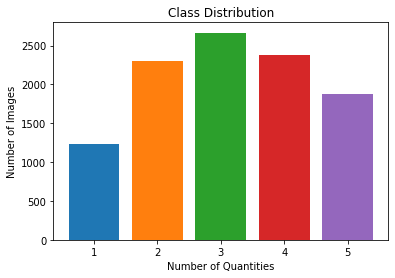

In [7]:
#TODO: Perform any data cleaning or data preprocessing
with open('file_list.json', 'r') as f:
    d =  json.load(f)
    for k,v in d.items():
        plt.bar(k,len(d[k]))
        plt.title('Class Distribution')
        plt.xlabel('Number of Quantities')
        plt.ylabel('Number of Images')

In [9]:
bucket = sagemaker_session.default_bucket()
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket

In [10]:
#TODO: Upload the data to AWS S3
#%%capture
#!aws s3 cp 'amazon-bin-images' s3://capstone-project-abid/ --recursivea
!aws s3 sync ./'amazon-bin-images' s3://${DEFAULT_S3_BUCKET}/BinImages/
    

upload: amazon-bin-images/test/1/00014.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/00014.jpg
upload: amazon-bin-images/test/1/02261.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/02261.jpg
upload: amazon-bin-images/test/1/00586.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/00586.jpg
upload: amazon-bin-images/test/1/00614.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/00614.jpg
upload: amazon-bin-images/test/1/00213.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/00213.jpg
upload: amazon-bin-images/test/1/00743.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/00743.jpg
upload: amazon-bin-images/test/1/00945.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/00945.jpg
upload: amazon-bin-images/test/1/01891.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/01891.jpg
upload: amazon-bin-images/test/1/01617.jpg to s3://sagemaker-us-east-1-304937755743/BinImages/test/1/01617.jpg
u

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [13]:
# Declare model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = { "test-batch-size": "100",
                   "batch-size": 64,
                   "lr": 0.05}
hyperparameters

{'test-batch-size': '100', 'batch-size': 64, 'lr': 0.05}

In [14]:
# Create training estimator
estimator = PyTorch(
    entry_point = "train.py",
    base_job_name = "amazonbin-imgclassification",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.g4dn.2xlarge",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path = "s3://sagemaker-us-east-1-304937755743/output/"
)

In [15]:
# TODO: Fit your estimator
input_data = "s3://{}/{}/".format(bucket, "BinImages")
estimator.fit({'train' :  input_data},wait=True)

2022-02-19 09:30:07 Starting - Starting the training job...ProfilerReport-1645263006: InProgress
......
2022-02-19 09:31:28 Starting - Preparing the instances for training......
2022-02-19 09:32:37 Downloading - Downloading input data............
2022-02-19 09:34:28 Training - Downloading the training image...............
2022-02-19 09:37:09 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-19 09:36:57,805 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-19 09:36:57,826 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-19 09:36:57,833 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-19 09:36:58,397 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "cha

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [38]:
#TODO: Create your hyperparameter search space
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

#TODO: Create your hyperparameter search space
hyperparameters = {"test-batch-size": "100"}
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256])
}

In [39]:
#TODO: Create your training estimator
# Create training estimator
estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "hpotuning-abid-project",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.g4dn.2xlarge", #"ml.m5.large"
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 2,
    max_parallel_jobs = 2,
    objective_type = objective_type,
)

In [40]:
# TODO: Fit your estimator
# Fit your estimator
input_data = "s3://{}/{}/".format(bucket, "BinImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "hpo-output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= input_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

tuner.fit({'train' :  input_data},wait=True)

.........................................................................................!


In [42]:
# TODO: Find the best hyperparameters
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
 

Exception: Best training job not available for tuning job: pytorch-training-220219-1125

In [43]:

best_hyperparameters = { "test-batch-size": "100",
                   "batch-size": 64,
                   "lr": 0.05}
hyperparameters

{'test-batch-size': '100',
 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-304937755743/hpotuning-abid-project-2022-02-19-11-25-25-375/source/sourcedir.tar.gz',
 'sagemaker_program': 'hpo.py',
 'sagemaker_container_log_level': 20,
 'sagemaker_job_name': 'hpotuning-abid-project-2022-02-19-11-25-25-375',
 'sagemaker_region': 'us-east-1'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [44]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig,CollectionConfig,ProfilerConfig,FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]
debugger_config=DebuggerHookConfig( collection_configs=collection_configs )


In [45]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point = "train.py",
    base_job_name = "best-abid-capstone",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.g4dn.2xlarge",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path = "s3://sagemaker-us-east-1-304937755743/output-best/",
    rules = rules,
    profiler_config = profiler_config,
    debugger_hook_config = hook_config
)

In [46]:

estimator.fit({'train' : input_data },wait=True)

2022-02-19 11:36:18 Starting - Starting the training job...
2022-02-19 11:36:47 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-02-19 11:38:08 Starting - Preparing the instances for training......
2022-02-19 11:39:08 Downloading - Downloading input data............
2022-02-19 11:41:09 Training - Downloading the training image.........
2022-02-19 11:42:50 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-19 11:42:40,551 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-19 11:42:40,571 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-19 11:42:42,013 sagemaker_pytorch_container.training INFO     Invoking user tra

In [47]:
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
print(f"client: {client}")
print(f"description: {description}")



Training jobname: best-abid-capstone-2022-02-19-11-36-17-558
Region: us-east-1
client: <botocore.client.SageMaker object at 0x7ff74cce6710>
description: {'TrainingJobName': 'best-abid-capstone-2022-02-19-11-36-17-558', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:304937755743:training-job/best-abid-capstone-2022-02-19-11-36-17-558', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-304937755743/output-best/best-abid-capstone-2022-02-19-11-36-17-558/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"best-abid-capstone-2022-02-19-11-36-17-558"', 'sagemaker_program': '"train.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-304937755743/best-abid-capstone-2022-02-19-11-36-17-558/source/sourcedir.tar.gz"', 'test-batch-size': '"100"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [48]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

[2022-02-19 12:02:12.326 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3372 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-304937755743/output-best/best-abid-capstone-2022-02-19-11-36-17-558/debug-output
[2022-02-19 12:02:15.237 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3372 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-19 12:02:16.264 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3372 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.3.r

In [49]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


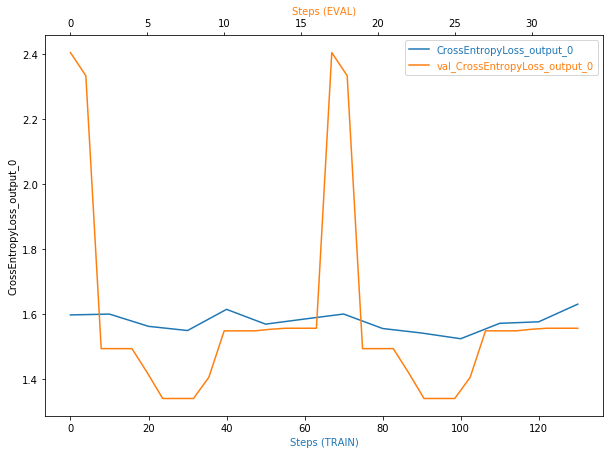

In [50]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [51]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [52]:
! aws s3 ls {rule_output_path} --recursive

2022-02-19 11:45:09     378214 output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-19 11:45:08     227418 output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-19 11:45:03        191 output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-19 11:45:03      10394 output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-19 11:45:03       1873 output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-19 11:45:03        129 output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-19 11:45:03       8554 output-best

In [53]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-304937755743/output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-304937755743/output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-304937755743/output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-304937755743/output-best/best-abid-capstone-2022-02-19-11-36-17-558/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.jso

In [54]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [55]:
%%capture
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [56]:
model_location=estimator.model_data
model_location

's3://sagemaker-us-east-1-304937755743/output-best/best-abid-capstone-2022-02-19-11-36-17-558/output/model.tar.gz'

In [57]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_location,
                            role = role,
                             entry_point= "endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.g4dn.xlarge") #Using ml.t2.medium to save costs

-------!

In [58]:
endpoint_name = predictor.endpoint_name
endpoint_name

'pytorch-inference-2022-02-19-12-06-33-476'

Testing 4 Different images
Test no: 1


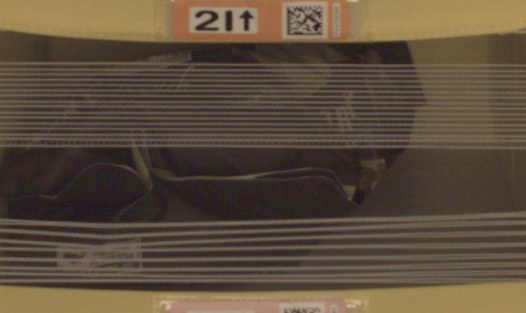

actual object count  : 1
Response: [[-0.61750883  0.2919696   0.44517383  0.23732242  0.229322  ]]
 predicted Response/Inference for the above image is : [3]
Testing 4 Different images
Test no: 2


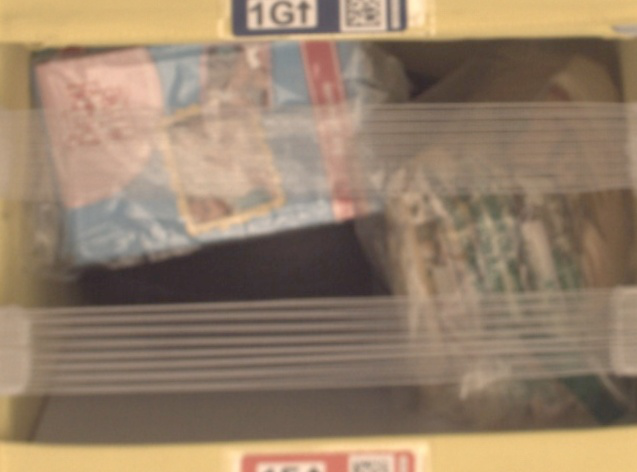

actual object count  : 2
Response: [[-0.61750883  0.2919696   0.44517383  0.23732242  0.229322  ]]
 predicted Response/Inference for the above image is : [3]
Testing 4 Different images
Test no: 3


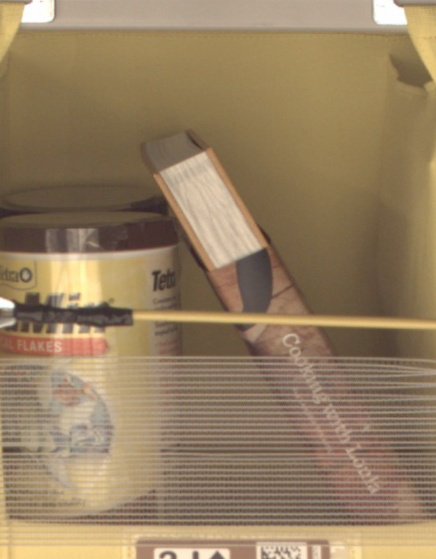

actual object count  : 3
Response: [[-0.61750883  0.2919696   0.44517383  0.23732242  0.229322  ]]
 predicted Response/Inference for the above image is : [3]
Testing 4 Different images
Test no: 4


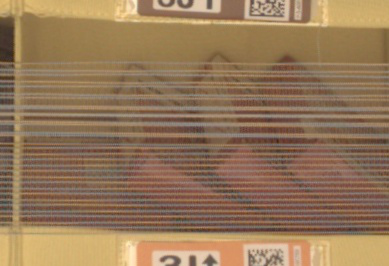

actual object count  : 4
Response: [[-0.61750883  0.2919696   0.44517383  0.23732242  0.229322  ]]
 predicted Response/Inference for the above image is : [3]
Testing 4 Different images
Test no: 5


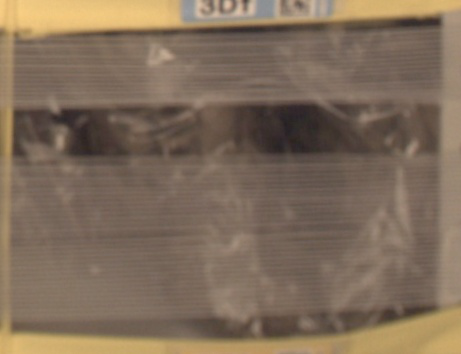

actual object count  : 5
Response: [[-0.61750883  0.2919696   0.44517383  0.23732242  0.229322  ]]
 predicted Response/Inference for the above image is : [3]


In [62]:
import json
import base64
import PIL
from PIL import Image
import io
import numpy as np
import boto3
import os
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_image_path = "./test_images"
test_images = [ '00014.jpg', '00250.jpg', '00903.jpg','00705.jpg','01047.jpg']
test_images_actual = [1,2,3,4,5 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    actual_img_count = test_images_actual[index] 
    print("Testing 4 Different images")
    test_file_path = os.path.join(test_image_path,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print(f"Test no: {index+1}")
        display(Image.open(io.BytesIO(payload)))
        print(f"actual object count  : {actual_img_count}")
        response = runtime.invoke_endpoint(EndpointName='pytorch-inference-2022-02-19-12-06-33-476',
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_img_count = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f" predicted Response/Inference for the above image is : {predicted_img_count}")

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances